In [90]:
# Import libraries
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [47]:
# Fetch stock data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df

In [48]:
# Exponential smoothing (referenced paper's formula)
def exponential_smoothing(series, alpha):
    result = [series.iloc[0]]
    for t in range(1, len(series)):
        result.append(alpha * series.iloc[t] + (1 - alpha) * result[t - 1])
    return pd.Series(result, index=series.index)

In [49]:
# Technical Indicators (as specified in the referenced paper)
def calculate_technical_indicators(df):
    smoothed_close = exponential_smoothing(df['Close'], alpha=0.9)
    df['RSI'] = calculate_RSI(smoothed_close)
    df['Stochastic'] = calculate_stochastic_oscillator(df)
    df['Williams_R'] = calculate_williams_r(df)
    df['MACD'] = calculate_MACD(smoothed_close)
    df['ROC'] = calculate_ROC(smoothed_close)
    df['OBV'] = calculate_OBV(df)
    return df

In [50]:
# Calculate RSI
def calculate_RSI(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [51]:
# Stochastic Oscillator
def calculate_stochastic_oscillator(df, period=14):
    low_min = df['Low'].rolling(window=period).min()
    high_max = df['High'].rolling(window=period).max()
    return 100 * ((df['Close'] - low_min) / (high_max - low_min))

In [52]:
# Williams %R
def calculate_williams_r(df, period=14):
    high_max = df['High'].rolling(window=period).max()
    low_min = df['Low'].rolling(window=period).min()
    return -100 * ((high_max - df['Close']) / (high_max - low_min))

In [53]:
# MACD Calculation
def calculate_MACD(prices):
    exp1 = prices.ewm(span=12, adjust=False).mean()
    exp2 = prices.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd - signal


In [54]:
# ROC Calculation
def calculate_ROC(prices, period=10):
    return prices.pct_change(periods=period) * 100

In [55]:
# On Balance Volume (OBV)
def calculate_OBV(df):
    return (np.sign(df['Close'].diff()) * df['Volume']).cumsum()

In [56]:
# Create Labels for Binary Classification
def create_labels(df, forward_days):
    future_price = df['Close'].shift(-forward_days)
    df['Target'] = np.sign(future_price - df['Close'])
    df['Target'] = df['Target'].apply(lambda x: 1 if x > 0 else 0)
    return df

In [57]:
# Prepare Data for Modeling
def prepare_data(ticker, start_date, end_date, forward_days):
    df = fetch_stock_data(ticker, start_date, end_date)
    df = calculate_technical_indicators(df)
    df = create_labels(df, forward_days)
    df = df.dropna()
    features = ['RSI', 'Stochastic', 'Williams_R', 'MACD', 'ROC', 'OBV']
    X = df[features]
    y = df['Target']
    return X, y

In [73]:
# Train and Evaluate Model with Grid Search
def train_and_evaluate_model(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [45, 55, 65, 75], 
        'max_depth': [8, 12]
    }
    rf_model = RandomForestClassifier(oob_score=True, random_state=0, bootstrap=True)
    grid_search = GridSearchCV(rf_model, param_grid, cv=tscv, scoring='accuracy')
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    oob_error = 1 - best_model.oob_score_
    return best_model, oob_error

In [100]:
# Plot ROC Curves 
def plot_roc_curve(fpr, tpr, roc_auc, label):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

In [76]:
# Describe data
start_date = (datetime.now() - timedelta(days=7000)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
X_a, y_a = prepare_data('AAPL', start_date, end_date, days)
X_ge, y_ge = prepare_data('GE', start_date, end_date, days)
X_s, y_s = prepare_data('005930.KS', start_date, end_date, days)

In [81]:
X_a.describe()

,RSI,Stochastic,Williams_R,MACD,ROC,OBV
count,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4.810000e+03
mean,56.456114,59.790134,-40.209866,0.004098,1.223090,3.390354e+10
std,19.423319,30.959823,30.959823,0.453776,6.125631,1.317810e+10
min,2.057122,0.000000,-100.000000,-2.441002,-32.483748,-9.035163e+09
25%,42.142191,32.395198,-67.604802,-0.069950,-2.472976,3.210986e+10
50%,56.911889,66.827556,-33.172444,0.003044,1.412409,3.973107e+10
75%,71.345182,88.072690,-11.927310,0.078809,5.114310,4.278509e+10
max,99.312256,100.000000,-0.000000,2.323446,29.654473,5.129078e+10


In [82]:
X_ge.describe()

,RSI,Stochastic,Williams_R,MACD,ROC,OBV
count,4810.000000,4810.000000,4810.000000,4810.000000,4810.000000,4.810000e+03
mean,51.644075,52.223820,-47.776180,-0.002697,0.328149,-1.917025e+08
std,18.806835,30.784947,30.784947,0.462550,6.605792,4.218062e+08
min,2.515426,0.000000,-100.000000,-2.375882,-39.311315,-1.173055e+09
25%,38.199133,24.324362,-75.675638,-0.270212,-2.624568,-5.138663e+08
50%,51.365712,53.495848,-46.504152,-0.011163,0.219954,-1.729388e+08
75%,65.019761,81.183485,-18.816515,0.279500,3.331518,1.123828e+08
max,99.267990,100.000000,-0.000000,2.022071,52.842152,5.957338e+08


In [83]:
X_s.describe()

,RSI,Stochastic,Williams_R,MACD,ROC,OBV
count,4729.000000,4.729000e+03,4729.000000,4729.000000,4729.000000,4.729000e+03
mean,51.871678,5.251095e+01,-47.489051,-0.647173,0.529752,2.944122e+08
std,16.926736,3.117267e+01,31.172667,205.421375,5.111101,4.484307e+08
min,0.948003,-2.649336e-13,-100.000000,-1368.363960,-25.122844,-6.907428e+08
25%,39.470572,2.432446e+01,-75.675537,-71.294469,-2.750933,-8.290625e+07
50%,51.604187,5.338982e+01,-46.610179,-0.063983,0.361756,1.968622e+08
75%,64.616827,8.153864e+01,-18.461356,73.900897,3.825220,6.550307e+08
max,97.547708,1.000000e+02,-0.000000,1099.889465,26.111632,1.533145e+09


In [84]:
y_a.describe()

count    4810.000000
mean        0.726195
std         0.445956
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Target, dtype: float64

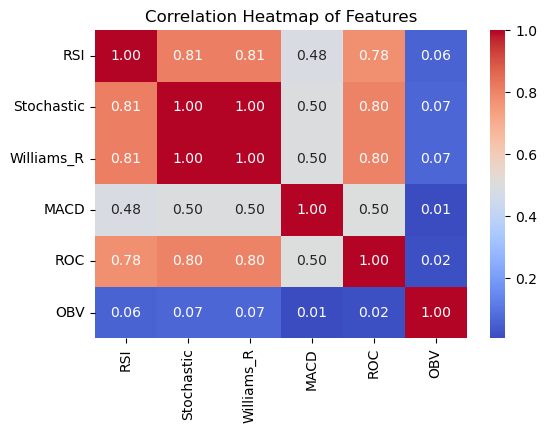

In [101]:
# Correlation matrix of Apple's features
correlation_matrix = X_a.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

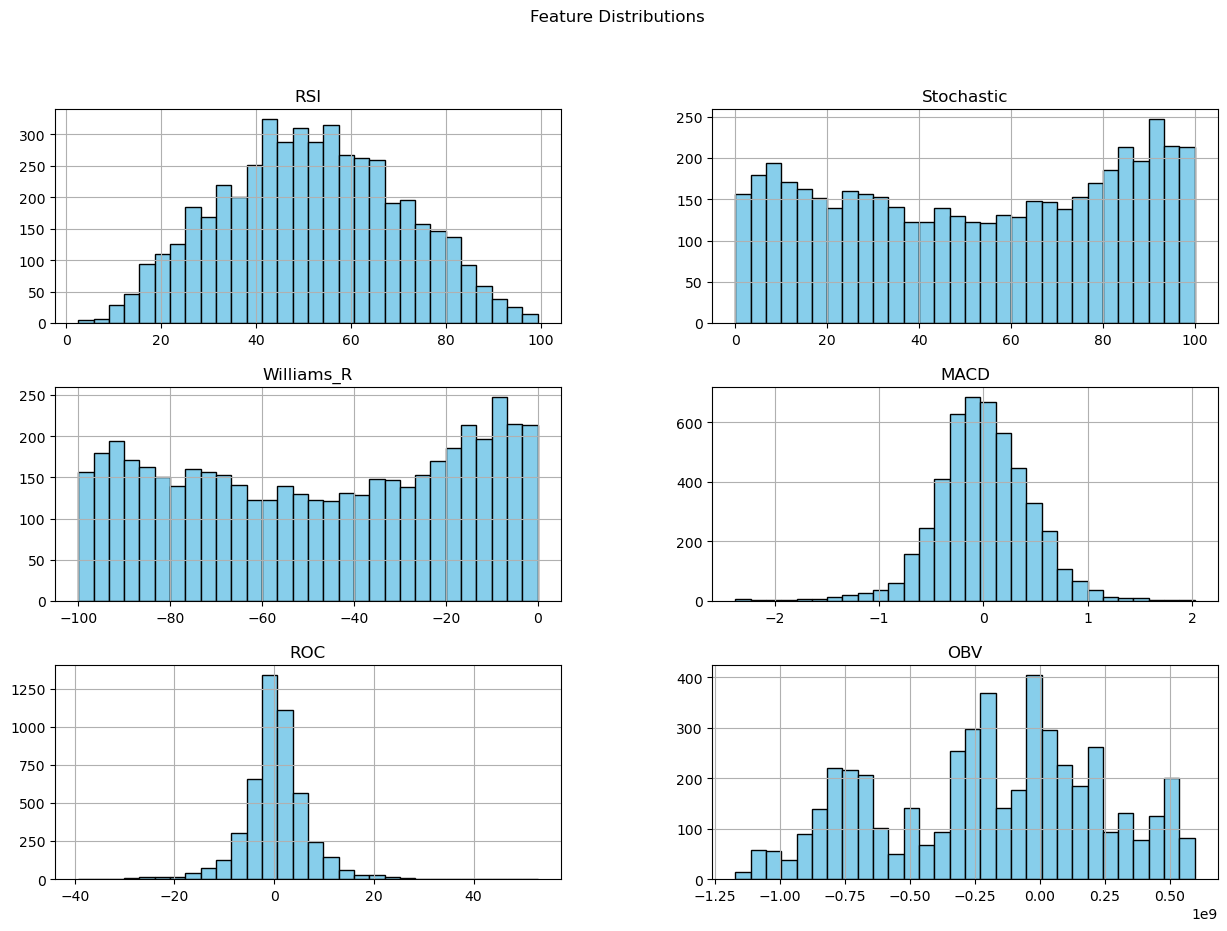

In [95]:
# Histograms for each feature of GE
X_ge.hist(bins=30, figsize=(15, 10), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions")
plt.show()

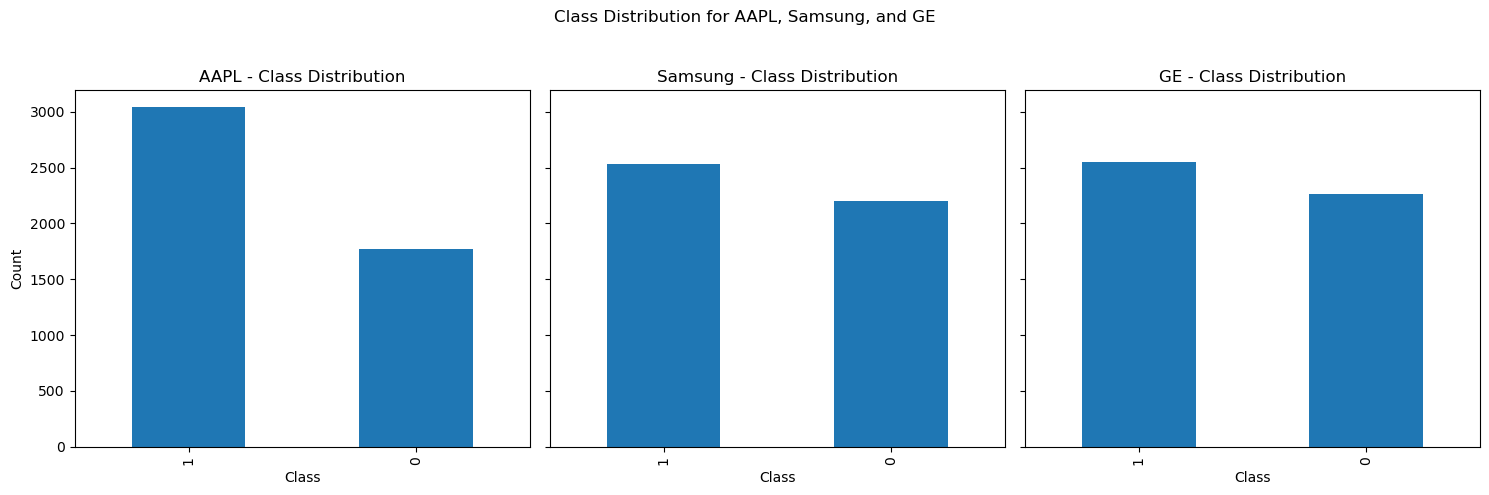

In [99]:
# Count the occurrences of each class for AAPL, Samsung, and GE
stocks = {'AAPL': y_a, 'Samsung': y_s, 'GE': y_ge}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (stock, y) in zip(axes, stocks.items()):
    target_counts = y.value_counts()
    target_counts.plot(kind='bar', ax=ax)
    ax.set_title(f"{stock} - Class Distribution")
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

plt.suptitle('Class Distribution for AAPL, Samsung, and GE')
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()



Analyzing AAPL
AAPL 30d: AUC = 0.85, OOB Error = 0.33
AAPL 60d: AUC = 0.87, OOB Error = 0.28
AAPL 90d: AUC = 0.89, OOB Error = 0.24


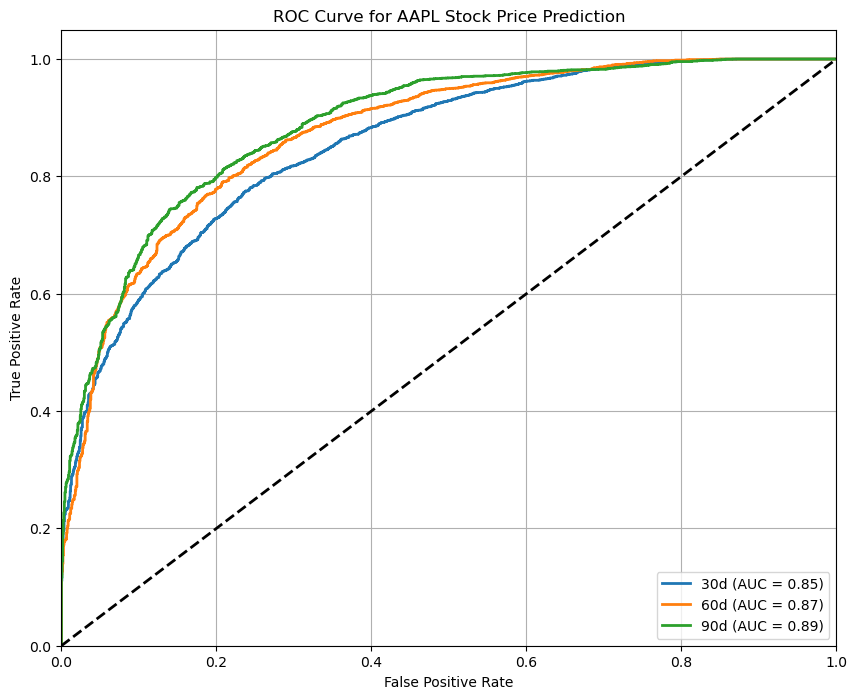


Analyzing GE
GE 30d: AUC = 0.87, OOB Error = 0.35
GE 60d: AUC = 0.89, OOB Error = 0.31
GE 90d: AUC = 0.99, OOB Error = 0.26


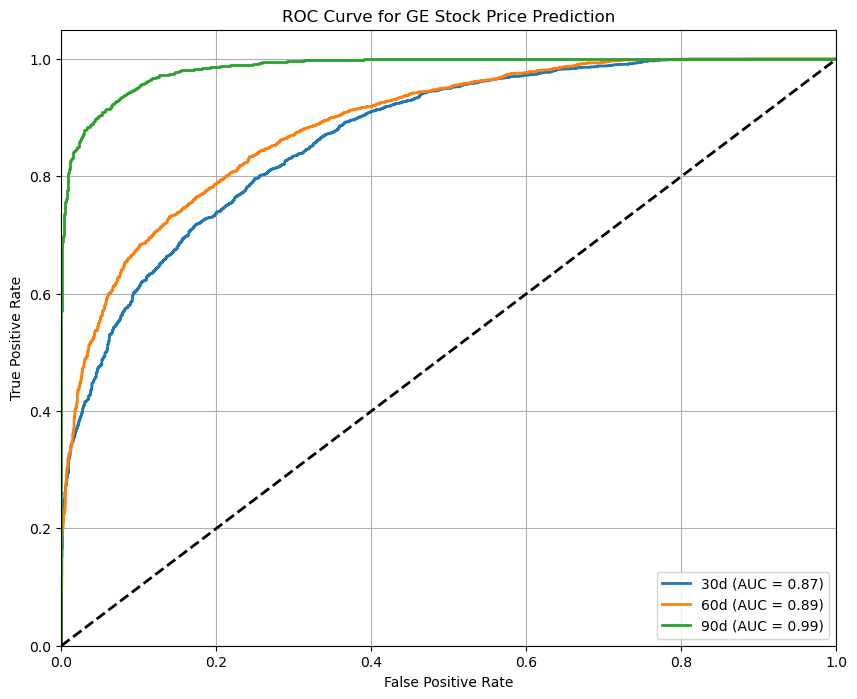


Analyzing 005930.KS
005930.KS 30d: AUC = 0.97, OOB Error = 0.35
005930.KS 60d: AUC = 0.86, OOB Error = 0.36
005930.KS 90d: AUC = 0.97, OOB Error = 0.31


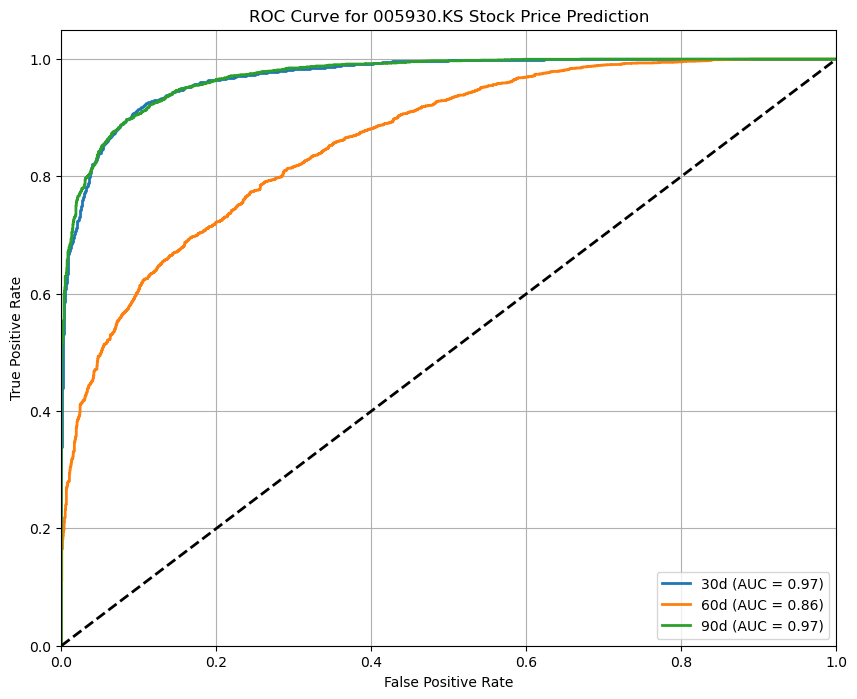


OOB Error Table:
Stock                  005930.KS      AAPL        GE
Trading Period (Days)                               
30                      0.352506  0.327027  0.352183
60                      0.361176  0.278586  0.314761
90                      0.310848  0.242620  0.260499


In [75]:
if __name__ == "__main__":
    tickers = ['AAPL', 'GE', '005930.KS']
    start_date = (datetime.now() - timedelta(days=7000)).strftime('%Y-%m-%d')
    end_date = datetime.now().strftime('%Y-%m-%d')
    prediction_windows = [30, 60, 90]

    results = []

    for ticker in tickers:
        plt.figure(figsize=(10, 8))
        print(f"\nAnalyzing {ticker}")
        for days in prediction_windows:
            X, y = prepare_data(ticker, start_date, end_date, days)
            best_model, oob_error = train_and_evaluate_model(X, y)
            y_pred_proba = best_model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plot_roc_curve(fpr, tpr, roc_auc, f'{days}d')
            results.append([days, ticker, best_model.n_estimators, len(X), oob_error])
            print(f"{ticker} {days}d: AUC = {roc_auc:.2f}, OOB Error = {oob_error:.2f}")
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {ticker} Stock Price Prediction')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    oob_df = pd.DataFrame(results, columns=['Trading Period (Days)', 'Stock', 'No. of Trees', 'Sample Size', 'OOB Error'])
    oob_df = oob_df.sort_values(by=['Trading Period (Days)', 'Stock'])
    print("\nOOB Error Table:")
    print(oob_df.pivot(index='Trading Period (Days)', columns='Stock', values='OOB Error'))


In [102]:
print(best_model)

RandomForestClassifier(max_depth=12, n_estimators=45, oob_score=True,
                       random_state=0)
